In [1]:
import nibabel as nib
from matplotlib import pyplot as plt
import os
import pickle
import numpy as np

#NN
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow.keras.backend as K

# Metrics
from sklearn.metrics import classification_report

# GPU
from tensorflow.python.client import device_lib

C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\matth\anaconda3\envs\gw\lib\site-packages\tensorflow\python\framework\dty

In [2]:
# Check GPU Detected
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15851140056640102959
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7129487770
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13317517147857635900
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


## Functions

In [3]:
def showImage(img, title):
    plt.imshow(img, cmap = "gray", origin = 'upper')
    plt.title(title), plt.xticks([]), plt.yticks([])
    plt.show()

In [4]:
def saveModel(directory_name, model, history):
    

    model.save(directory_name + "_Model.h5")

In [5]:
#https://medium.com/@aakashgoel12/how-to-add-user-defined-function-get-f1-score-in-keras-metrics-3013f979ce0d#:~:text=By%20default,%20f1%20score%20is%20not%20part%20of,each%20epoch,%20need%20to%20make%20some%20more%20efforts.
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [6]:
def matthews_correlation(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    return numerator / (denominator + K.epsilon())

In [7]:
#https://github.com/mkocabas/focal-loss-keras/blob/master/focal_loss.py
gamma = 2
alpha = .25
def focal_loss_fixed(y_true, y_pred):
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
    return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))

## Grouping Files into Datasets

In [8]:
#base_path="C:/Users/drago/Documents/gitrepos/individual-project-alzhiemers_detection/MRI Data/WM parc data - cropped images/Blur_Contour_Crop/"
base_path="C:/Users/matth/OneDrive - University of Reading/Documents/Year 3 Documents/Final Year Project/Git Large File Storage/MRI Data/WM parc data - cropped images/Blur_Contour_Crop/"

In [9]:
# Break:
# 196 : 97 : 97
# 359 : 178 : 178

In [10]:
# File setup check
print("Total training AD: ", len(os.listdir(base_path+"1-Train/AD")))
print("Total validation AD: ", len(os.listdir(base_path+"2-Validation/AD")))
print("Total testing AD: ", len(os.listdir(base_path+"3-Test/AD")))

print("\nTotal training CN: ", len(os.listdir(base_path+"1-Train/CN")))
print("Total validation CN: ", len(os.listdir(base_path+"2-Validation/CN")))
print("Total testing CN: ", len(os.listdir(base_path+"3-Test/CN")))

Total training AD:  196
Total validation AD:  97
Total testing AD:  97

Total training CN:  359
Total validation CN:  178
Total testing CN:  178


In [11]:
# Build from directory dataset generators
train_aug_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=5,
    width_shift_range=[-0.01, 0.01],
    height_shift_range=[-0.01, 0.01],
    zoom_range=[1-0.01, 1+0.01],
    fill_mode='nearest')

test_aug_datagen = ImageDataGenerator(rescale=1./255)

train_aug_generator = train_aug_datagen.flow_from_directory(
    base_path+"1-Train/",
    target_size=(255,255),
    batch_size=32,
    class_mode="binary")

validation_aug_generator = test_aug_datagen.flow_from_directory(
    base_path+"2-Validation/",
    target_size=(255,255),
    batch_size=32,
    class_mode="binary")

validating_generator = test_aug_datagen.flow_from_directory(
    base_path+"2-Validation/",
    target_size=(255,255),
    batch_size=32,
    shuffle=False,
    class_mode="binary")

test_aug_generator = test_aug_datagen.flow_from_directory(
    base_path+"3-test/",
    target_size=(255,255),
    batch_size=32,
    class_mode="binary")

Found 555 images belonging to 2 classes.
Found 275 images belonging to 2 classes.
Found 275 images belonging to 2 classes.
Found 275 images belonging to 2 classes.


### Data Preprosessing

In [12]:
# Check batches shape
for batch, label in train_aug_generator:
    print("data batch shape: ", batch.shape)
    print("label shape: ", label.shape)
    break

data batch shape:  (32, 255, 255, 3)
label shape:  (32,)


## Construct Model- 2 Dense

In [13]:
# Construct model
conv_base = VGG16(weights='imagenet',
                 include_top=False,
                 input_shape=(255, 255, 3))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [14]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 255, 255, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 255, 255, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 255, 255, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 127, 127, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 127, 127, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 127, 127, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 63, 63, 128)       0     

In [15]:
augmentedVGG16 = models.Sequential()
augmentedVGG16.add(conv_base)
augmentedVGG16.add(layers.Flatten())
augmentedVGG16.add(layers.Dense(256, activation='relu'))
augmentedVGG16.add(layers.Dense(1, activation='sigmoid'))
augmentedVGG16.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               6422784   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 21,137,729
Trainable params: 21,137,729
Non-trainable params: 0
_________________________________________________________________


In [16]:
# Freeze CNN
conv_base.trainable=False

In [17]:
# Model Compile
augmentedVGG16.compile(optimizer=optimizers.RMSprop(lr=2e-5),
                         loss=focal_loss_fixed,
                         metrics=['acc'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### Fitting and Saving Model

In [18]:
base_directory = "C:/Users/matth/OneDrive - University of Reading/Documents/Year 3 Documents/Final Year Project/Git Large File Storage/Models/VGG16_Aug_FL_Acc - 2_0/"
best_model_file = base_directory + "best_model.hdf5"
history_file_name = base_directory + "History.pkl"
info_file_name = base_directory + "README.md"
model_content = """Base: VGG16
Dense: 2
Augmentation: 5 degree, width_shift: [-0.01, 0.01], height_shift: [-0.01, 0.01], zoom_range: [1-0.01, 1+0.01]
Batch_size:32
Optimizer: RMSProp
Lr: 2e-5
Loss: Focal Loss Fixed
Metric: Accuracy
Epochs: 100
"""

with open(info_file_name, 'w') as readme_file:
       readme_file.write(model_content)

In [19]:
# Create checkpoint callback to store best acc to loss model
checkpoint = ModelCheckpoint(filepath=best_model_file, save_best_only=True)

# Fit model
VGG16_history = augmentedVGG16.fit_generator(
    train_aug_generator,
    steps_per_epoch=len(train_aug_generator),
    epochs=100,
    callbacks=[checkpoint],
    validation_data=validation_aug_generator,
    validation_steps=len(validation_aug_generator))

save_history = VGG16_history.history
# Save history
with open(history_file_name, 'wb') as file_pi:
        pickle.dump(save_history, file_pi)

Epoch 1/100
18/18 [==============================] - 12s 672ms/step - loss: 0.0900 - acc: 0.4577 - val_loss: 0.0712 - val_acc: 0.3673
Epoch 2/100
18/18 [==============================] - 6s 358ms/step - loss: 0.0725 - acc: 0.5063 - val_loss: 0.0674 - val_acc: 0.6836
Epoch 3/100
18/18 [==============================] - 7s 404ms/step - loss: 0.0636 - acc: 0.5892 - val_loss: 0.0656 - val_acc: 0.4800
Epoch 4/100
18/18 [==============================] - 7s 415ms/step - loss: 0.0655 - acc: 0.5712 - val_loss: 0.0628 - val_acc: 0.6073
Epoch 5/100
18/18 [==============================] - 7s 403ms/step - loss: 0.0599 - acc: 0.6234 - val_loss: 0.0705 - val_acc: 0.7236
Epoch 6/100
18/18 [==============================] - 7s 411ms/step - loss: 0.0531 - acc: 0.7189 - val_loss: 0.0613 - val_acc: 0.6255
Epoch 7/100
18/18 [==============================] - 7s 405ms/step - loss: 0.0541 - acc: 0.6865 - val_loss: 0.0704 - val_acc: 0.7418
Epoch 8/100
18/18 [==============================] - 8s 418ms/step -

18/18 [==============================] - 7s 384ms/step - loss: 0.0102 - acc: 0.9694 - val_loss: 0.1188 - val_acc: 0.7455
Epoch 63/100
18/18 [==============================] - 7s 387ms/step - loss: 0.0098 - acc: 0.9766 - val_loss: 0.1045 - val_acc: 0.7673
Epoch 64/100
18/18 [==============================] - 7s 392ms/step - loss: 0.0109 - acc: 0.9766 - val_loss: 0.0793 - val_acc: 0.6582
Epoch 65/100
18/18 [==============================] - 7s 389ms/step - loss: 0.0089 - acc: 0.9802 - val_loss: 0.0961 - val_acc: 0.7600
Epoch 66/100
18/18 [==============================] - 7s 389ms/step - loss: 0.0101 - acc: 0.9784 - val_loss: 0.1019 - val_acc: 0.7491
Epoch 67/100
18/18 [==============================] - 7s 386ms/step - loss: 0.0089 - acc: 0.9910 - val_loss: 0.1211 - val_acc: 0.7527
Epoch 68/100
18/18 [==============================] - 7s 386ms/step - loss: 0.0097 - acc: 0.9784 - val_loss: 0.1163 - val_acc: 0.7564
Epoch 69/100
18/18 [==============================] - 7s 388ms/step - loss:

### Retrieving Saved Model and History

In [20]:
# Get history
with open(history_file_name, 'rb') as file__pi:
    VGG16_history = pickle.load(file__pi)
    
# Get best model
VGG16_best = models.load_model(best_model_file, custom_objects={"focal_loss_fixed": focal_loss_fixed})
#Temp for unused metrics
#, "get_f1": get_f1, "matthews_correlation": matthews_correlation

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


### Plotting Results

In [21]:
accuracy = VGG16_history['acc']
validation_accuracy = VGG16_history['val_acc']

loss = VGG16_history['loss']
validation_loss = VGG16_history['val_loss']
"""
precision = VGG16_augmented_history.history['precision']
validation_precision = VGG16_augmented_history.history['val_precision']
recall = VGG16_augmented_history.history['recall']
validation_recall = VGG16_augmented_history.history['val_recall']
f1 = VGG16_augmented_history.history['get_f1']
validation_f1 = VGG16_augmented_history.history['val_get_f1']
mcc = VGG16_augmented_history.history['matthews_correlation']
validation_mcc = VGG16_augmented_history.history['val_matthews_correlation']
"""

"\nprecision = VGG16_augmented_history.history['precision']\nvalidation_precision = VGG16_augmented_history.history['val_precision']\nrecall = VGG16_augmented_history.history['recall']\nvalidation_recall = VGG16_augmented_history.history['val_recall']\nf1 = VGG16_augmented_history.history['get_f1']\nvalidation_f1 = VGG16_augmented_history.history['val_get_f1']\nmcc = VGG16_augmented_history.history['matthews_correlation']\nvalidation_mcc = VGG16_augmented_history.history['val_matthews_correlation']\n"


best_avg_acc:  0.6472727
best_avg_loss:  0.058852479275729924
              precision    recall  f1-score   support

          AD       0.50      0.81      0.62        97
          CN       0.85      0.56      0.67       178

    accuracy                           0.65       275
   macro avg       0.67      0.69      0.65       275
weighted avg       0.72      0.65      0.65       275



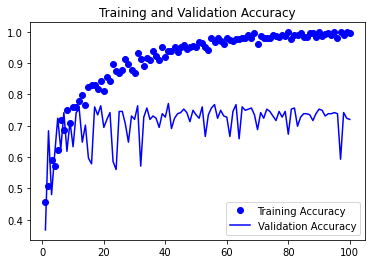

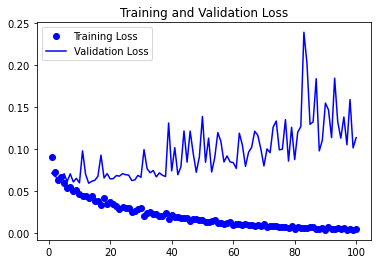

<Figure size 432x288 with 0 Axes>

In [22]:
epochs = range(1, len(accuracy) + 1)

# Accuracy Plots
plt.plot(epochs, accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'b', label='Validation Accuracy')
plt.title("Training and Validation Accuracy")
plt.legend()

plt.figure()

# Loss Plots
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, validation_loss, 'b', label='Validation Loss')
plt.title("Training and Validation Loss")
plt.legend()

plt.figure()

"""
# Generate acc loss percentages
train_loss, train_acc, train_precision, train_recall, train_f1, train_mcc = augmentedVGG16.evaluate_generator(train_aug_generator, steps=len(train_aug_generator))
print("\ntrain_acc: ", train_acc)
print("train_precision: ", train_precision)
print("train_recall: ", train_recall)
print("train_f1: ", train_f1)
print("train_mcc: ", train_mcc)
print("train_loss: ", train_loss)

# Generate acc loss percentages
valid_loss, valid_acc, valid_precision, valid_recall, valid_f1, valid_mcc = augmentedVGG16.evaluate_generator(validation_aug_generator, steps=len(validation_aug_generator))
print("\nvalid_acc: ", valid_acc)
print("valid_precision: ", valid_precision)
print("valid_recall: ", valid_recall)
print("valid_f1: ", valid_f1)
print("valid_mcc: ", valid_mcc)
print("valid_loss: ", valid_loss)
"""

# Output best epoch acc loss percentages
best_loss, best_acc = VGG16_best.evaluate_generator(validation_aug_generator, steps=len(validation_aug_generator))
print("\nbest_avg_acc: ", best_acc)
print("best_avg_loss: ", best_loss)

# Classification metric matrix: precision, recall, f1-score, support
val_preds = np.round(VGG16_best.predict_generator(validating_generator),0)
val_trues = validation_aug_generator.classes

# Label data
classes = np.array(list(validating_generator.class_indices.keys()))

print(classification_report(val_trues, val_preds, target_names = classes))

## Fine Tune

In [23]:
base_directory = "C:/Users/matth/OneDrive - University of Reading/Documents/Year 3 Documents/Final Year Project/Git Large File Storage/Models/VGG16_Aug_FL_Acc_FT - 2_0/"
best_model_file = base_directory + "best_model.hdf5"
history_file_name = base_directory + "History.pkl"
info_file_name = base_directory + "README.md"
model_content = """Base: VGG16_best\n
Augmentation: 5 degree, width_shift: [-0.01, 0.01], height_shift: [-0.01, 0.01], zoom_range: [1-0.01, 1+0.01]\n
Batch_size: 32\n
Optimizer: RMSProp\n
Lr: 1e-5\n 
Loss: Focal Loss Fixed\n
Metric: Accuracy\n
Epochs: 100
"""

with open(info_file_name, 'w') as readme_file:
       readme_file.write(model_content)

### Set trainable higher layers

In [24]:
VGG16_best.get_layer(name="vgg16").summary()
vgg16_base = VGG16_best.get_layer(name="vgg16")
vgg16_base.trainable = True

set_trainable = False
for layer in vgg16_base.layers:
    if layer.name == "block5_conv1":
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        
VGG16_best.get_layer(name="vgg16").summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 255, 255, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 255, 255, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 255, 255, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 127, 127, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 127, 127, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 127, 127, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 63, 63, 128)       0     

### Compile and fit

In [25]:
# Model Compile
VGG16_best.compile(optimizer=optimizers.RMSprop(lr=1e-5),
                         loss=focal_loss_fixed,
                         metrics=['acc'])

In [26]:
# Create checkpoint callback to store best acc to loss model
checkpoint = ModelCheckpoint(filepath=best_model_file, save_best_only=True)

# Fit model
VGG16_FT_history = VGG16_best.fit_generator(
    train_aug_generator,
    steps_per_epoch=len(train_aug_generator),
    epochs=100,
    callbacks=[checkpoint],
    validation_data=validation_aug_generator,
    validation_steps=len(validation_aug_generator))

save_history = VGG16_FT_history.history
# Save history
with open(history_file_name, 'wb') as file_pi:
        pickle.dump(save_history, file_pi)

Epoch 1/100
18/18 [==============================] - 9s 515ms/step - loss: 0.0451 - acc: 0.8054 - val_loss: 0.0637 - val_acc: 0.7273
Epoch 2/100
18/18 [==============================] - 7s 385ms/step - loss: 0.0322 - acc: 0.8468 - val_loss: 0.0639 - val_acc: 0.6800
Epoch 3/100
18/18 [==============================] - 8s 421ms/step - loss: 0.0294 - acc: 0.8649 - val_loss: 0.0889 - val_acc: 0.7527
Epoch 4/100
18/18 [==============================] - 8s 445ms/step - loss: 0.0285 - acc: 0.8703 - val_loss: 0.0965 - val_acc: 0.7491
Epoch 5/100
18/18 [==============================] - 8s 442ms/step - loss: 0.0262 - acc: 0.9027 - val_loss: 0.1106 - val_acc: 0.7455
Epoch 6/100
18/18 [==============================] - 7s 413ms/step - loss: 0.0239 - acc: 0.9027 - val_loss: 0.0864 - val_acc: 0.7564
Epoch 7/100
18/18 [==============================] - 8s 430ms/step - loss: 0.0200 - acc: 0.9171 - val_loss: 0.0675 - val_acc: 0.6582
Epoch 8/100
18/18 [==============================] - 8s 419ms/step - 

18/18 [==============================] - 7s 394ms/step - loss: 0.0013 - acc: 0.9928 - val_loss: 0.1446 - val_acc: 0.7673
Epoch 62/100
18/18 [==============================] - 7s 389ms/step - loss: 6.6529e-05 - acc: 1.0000 - val_loss: 0.1430 - val_acc: 0.7709
Epoch 63/100
18/18 [==============================] - 7s 386ms/step - loss: 4.8478e-05 - acc: 1.0000 - val_loss: 0.1682 - val_acc: 0.7745
Epoch 64/100
18/18 [==============================] - 7s 393ms/step - loss: 5.0387e-05 - acc: 1.0000 - val_loss: 0.1291 - val_acc: 0.7600
Epoch 65/100
18/18 [==============================] - 7s 398ms/step - loss: 0.0017 - acc: 0.9910 - val_loss: 0.1498 - val_acc: 0.7709
Epoch 66/100
18/18 [==============================] - 7s 390ms/step - loss: 4.2222e-05 - acc: 1.0000 - val_loss: 0.1579 - val_acc: 0.7673
Epoch 67/100
18/18 [==============================] - 7s 385ms/step - loss: 4.7286e-05 - acc: 1.0000 - val_loss: 0.1602 - val_acc: 0.7673
Epoch 68/100
18/18 [==============================] - 7

### Retrieving Saved Model and History

In [27]:
with open(history_file_name, 'rb') as file__pi:
    VGG16_FT_history = pickle.load(file__pi)
    
VGG16_FT_best = models.load_model(best_model_file, custom_objects={"focal_loss_fixed": focal_loss_fixed})
# Temp Comment out
# , "get_f1": get_f1, "matthews_correlation": matthews_correlation

### Plotting Results

In [28]:
accuracy = VGG16_FT_history['acc']
validation_accuracy = VGG16_FT_history['val_acc']

loss = VGG16_FT_history['loss']
validation_loss = VGG16_FT_history['val_loss']

"""
precision = VGG16_augmented_fine_tune_history['precision_1']
validation_precision = VGG16_augmented_fine_tune_history['val_precision_1']
recall = VGG16_augmented_fine_tune_history['recall_1']
validation_recall = VGG16_augmented_fine_tune_history['val_recall_1']
f1 = VGG16_augmented_fine_tune_history['get_f1']
validation_f1 = VGG16_augmented_fine_tune_history['val_get_f1']
mcc = VGG16_augmented_fine_tune_history['matthews_correlation']
validation_mcc = VGG16_augmented_fine_tune_history['val_matthews_correlation']
"""

"\nprecision = VGG16_augmented_fine_tune_history['precision_1']\nvalidation_precision = VGG16_augmented_fine_tune_history['val_precision_1']\nrecall = VGG16_augmented_fine_tune_history['recall_1']\nvalidation_recall = VGG16_augmented_fine_tune_history['val_recall_1']\nf1 = VGG16_augmented_fine_tune_history['get_f1']\nvalidation_f1 = VGG16_augmented_fine_tune_history['val_get_f1']\nmcc = VGG16_augmented_fine_tune_history['matthews_correlation']\nvalidation_mcc = VGG16_augmented_fine_tune_history['val_matthews_correlation']\n"


best_acc:  0.72727275
best_loss:  0.06244397246175342
              precision    recall  f1-score   support

          AD       0.59      0.74      0.66        97
          CN       0.84      0.72      0.77       178

    accuracy                           0.73       275
   macro avg       0.71      0.73      0.72       275
weighted avg       0.75      0.73      0.73       275



'\n# Output best epoch acc loss percentages\nbest_test_loss, best_test_acc, best_test_precision, best_test_recall, best_test_f1, best_test_mcc = VGG16_augmented_fine_tune_best.evaluate_generator(test_aug_generator, steps=len(test_aug_generator))\nprint("\nbest_test_acc: ", best_test_acc)\nprint("best_test_precision: ", best_test_precision)\nprint("best_test_recall: ", best_test_recall)\nprint("best_test_f1: ", best_test_f1)\nprint("best_test_mcc: ", best_test_mcc)\nprint("best_test_loss: ", best_test_loss)\n'

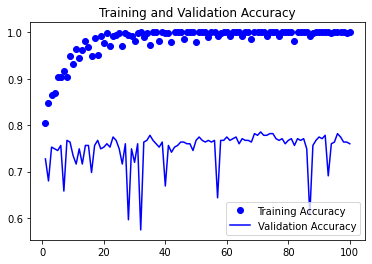

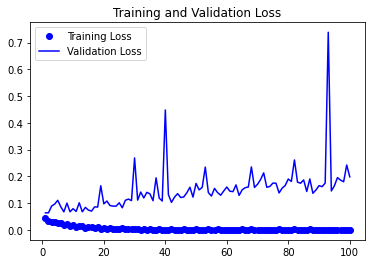

<Figure size 432x288 with 0 Axes>

In [29]:
epochs = range(1, len(accuracy) + 1)


# Accuracy Plots
plt.plot(epochs, accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'b', label='Validation Accuracy')
plt.title("Training and Validation Accuracy")
plt.legend()

plt.figure()

# Loss Plots
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, validation_loss, 'b', label='Validation Loss')
plt.title("Training and Validation Loss")
plt.legend()

plt.figure()

"""
# F1 Plots
plt.plot(epochs, f1, 'bo', label='Training F1')
plt.plot(epochs, validation_f1, 'b', label='Validation F1')
plt.title("Training and Validation F1")
plt.legend()

plt.figure()

# Generate acc loss percentages
train_loss, train_acc, train_precision, train_recall, train_f1, train_mcc = VGG16_aug_best.evaluate_generator(train_aug_generator, steps=len(train_aug_generator))
print("\ntrain_acc: ", train_acc)
print("train_precision: ", train_precision)
print("train_recall: ", train_recall)
print("train_f1: ", train_f1)
print("train_mcc: ", train_mcc)
print("train_loss: ", train_loss)

# Generate acc loss percentages
valid_loss, valid_acc, valid_precision, valid_recall, valid_f1, valid_mcc = VGG16_aug_best.evaluate_generator(validation_aug_generator, steps=len(validation_aug_generator))
print("\nvalid_acc: ", valid_acc)
print("valid_precision: ", valid_precision)
print("valid_recall: ", valid_recall)
print("valid_f1: ", valid_f1)
print("valid_mcc: ", valid_mcc)
print("valid_loss: ", valid_loss)
"""


# Output best epoch acc loss percentages
best_loss, best_acc = VGG16_FT_best.evaluate_generator(validation_aug_generator, steps=len(validation_aug_generator))
print("\nbest_acc: ", best_acc)
print("best_loss: ", best_loss)



# Classification metric matrix: precision, recall, f1-score, support
val_preds = np.round(VGG16_FT_best.predict_generator(validating_generator),0)
val_trues = validation_aug_generator.classes

# Label data
classes = np.array(list(validating_generator.class_indices.keys()))

print(classification_report(val_trues, val_preds, target_names = classes))

### Testing
"""
# Output best epoch acc loss percentages
best_test_loss, best_test_acc, best_test_precision, best_test_recall, best_test_f1, best_test_mcc = VGG16_augmented_fine_tune_best.evaluate_generator(test_aug_generator, steps=len(test_aug_generator))
print("\nbest_test_acc: ", best_test_acc)
print("best_test_precision: ", best_test_precision)
print("best_test_recall: ", best_test_recall)
print("best_test_f1: ", best_test_f1)
print("best_test_mcc: ", best_test_mcc)
print("best_test_loss: ", best_test_loss)
"""